In [13]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# Read in all the words
words = open('C:/Users/pchavan/The Bridge/MLStuff/makemore/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [15]:
#Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [16]:
#build the dataset

block_size = 3 # context lenght: how many characters do we tale to predict the next one

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])        #80%
Xdev, Ydev = build_dataset(words[n1:n2])    #10%
Xte, Yte = build_dataset(words[n2:])        #10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [17]:
#Utility tools that we'll use later when comparing manual gradients to PyTorch gradients 

def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exat: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [18]:
n_embd = 10 # The dimentionality of character embedding vectors
n_hidden = 64 # The number of neurons in the hidden layer of MLP

g = torch.Generator().manual_seed(2147483647)       # For reproducibility
C = torch.randn((vocab_size, n_embd),               generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5 / 3) / ((n_embd * block_size) ** 0.5)
b1 = torch.randn(n_hidden,                          generator=g) * 0.1      # b1 here is just for backprop practice; it's not required because of BN
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.1
b2 = torch.randn(vocab_size,                        generator=g) * 0.1
# Batchnorm Parameters
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

4137


In [19]:
batch_size = 32
n = batch_size # a shorter variable also, for conveniacnce

# Construct a minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]   # Batch X, Y

In [20]:
#forward pass, "chunkated" into smaller steps that are possible to backward one at a time 

emb = C[Xb]                                                     # embed the characters ontp vecters 
embcat = emb.view(emb.shape[0], -1)                             # Concate the vectors
# Linear Layer 1
hprebn = embcat @ W1 + b1                                       # hidden layer preactivation
# Batchnorm layer
bnmeani = 1/n * hprebn.sum(0, keepdim = True)
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = 1/(n-1) * bndiff2.sum(0, keepdim = True)
bnvar_inv = (bnvar + 1e-5) ** -0.5
bnraw = bndiff * bnvar_inv
hpreact = bngain * bnraw + bnbias
# Non-Linearity
h = torch.tanh(hpreact)                                         # Hidden layer
# Linear Layer 2 
logits = h @ W2 + b2                                            # Output Layer             
# Cross entropy loss (Same as F.cross_entropy(logits, Yb))
logit_maxes = logits.max(1, keepdim = True).values                            
norm_logits = logits - logit_maxes                              # normalizing Logits
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum ** -1                               
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward  pass
for p in parameters:
    p.grad = None

for t in [logprobs, probs, counts, counts_sum, counts_sum_inv
          , norm_logits, logit_maxes, logits, h, hpreact, bnraw
          , bnvar, bnvar_inv, bndiff, bndiff2, hprebn, bnmeani
          , embcat, emb]:
    t.retain_grad()
loss.backward()
loss

tensor(3.3343, grad_fn=<NegBackward0>)

## Becoming a backprop Ninja!

In [21]:
# Exercise 1: backprop through the whole thing manually, backpropagating through exactly all of the variables 
# as they are defined in the forward pass above, one by one

In [22]:
dlogprob = torch.zeros(logprobs.shape)
dlogprob[range(n), Yb] = -1/n
cmp('logprobs', dlogprob, logprobs)

dprobs = dlogprob * 1 / probs
cmp('probs', dprobs, probs)

dcounts_sum_inv = (counts * dprobs).sum(1, keepdim=True)
cmp('counts_sum_inv', dcounts_sum_inv, counts_sum_inv)

dcounts = dprobs * counts_sum_inv

dcounts_sum = dcounts_sum_inv * -1 * (counts_sum ** -2)
cmp('counts_sum', dcounts_sum, counts_sum)

dcounts += (torch.ones_like(counts) * dcounts_sum)
cmp('counts', dcounts, counts)

dnorm_logits = dcounts * norm_logits.exp()
cmp('norm_logits', dnorm_logits, norm_logits)

dlogits = dnorm_logits.clone()
dlogit_maxes = -dnorm_logits.sum(1, keepdim=True)
cmp('dlogit_maxes', dlogit_maxes, logit_maxes)

# tmp = torch.zeros_like(logits)
# tmp[range(n), (logits.max(1).indices)] = 1
# dlogits += dlogit_maxes * tmp

#OR

dlogits += dlogit_maxes * F.one_hot(logits.max(1).indices, num_classes=logits.shape[1])
cmp('dlogits', dlogits, logits)

dh = dnorm_logits @ W2.T
cmp('h', dh, h)

dW2 = h.T @ dlogits
cmp('W2', dW2, W2)

db2 = dnorm_logits.sum(0)
cmp('b2', db2, b2)

# dhpreact = dh * (4 / (torch.exp(hpreact) + torch.exp(-hpreact))**2)
dhpreact = dh * (1.0 - h**2)
cmp('hpreact', dhpreact, hpreact)

dbngain = (dhpreact * bnraw).sum(0, keepdim = True)
dbnraw = dhpreact * bngain
dbnbias = dhpreact.sum(0, keepdim=True)
cmp('dbngain', dbngain, bngain)
cmp('dbnraw', dbnraw, bnraw)
cmp('dbnbias', dbnbias, bnbias)

dbndiff = dbnraw * bnvar_inv
dbnvar_inv = (dbnraw * bndiff).sum(0, keepdim = True)
# cmp('dbndiff', dbndiff, bndiff)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)

dbnvar = dbnvar_inv * -0.5 * ((bnvar + 1e-5)**-1.5)
cmp('dbnvar', dbnvar, bnvar)

dbndiff2 = dbnvar * 1/(n-1) * torch.ones_like(bndiff2)
cmp('dbndiff2', dbndiff2, bndiff2)

dbndiff += dbndiff2 * 2 * bndiff
cmp('dbndiff', dbndiff, bndiff)

dhprebn = dbndiff.clone()
dbnmeani = -dbndiff.sum(0, keepdim=True)
cmp('dbnmeani', dbnmeani, bnmeani)

dhprebn += dbnmeani * 1/n * torch.ones_like(hprebn)
cmp('dhprebn', dhprebn, hprebn)

dembcat = dhprebn @ W1.T
dW1 = embcat.T @ dhprebn
db1 = dhprebn.sum(0)
cmp('dembcat', dembcat, embcat)
cmp('dW1', dW1, W1)
cmp('db1', db1, b1)

demb = dembcat.view(emb.shape)
cmp('demb', demb, emb)

dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k,j]
cmp('dC', dC, C)

logprobs        | exat: True  | approximate: True  | maxdiff: 0.0
probs           | exat: True  | approximate: True  | maxdiff: 0.0
counts_sum_inv  | exat: True  | approximate: True  | maxdiff: 0.0
counts_sum      | exat: True  | approximate: True  | maxdiff: 0.0
counts          | exat: True  | approximate: True  | maxdiff: 0.0
norm_logits     | exat: True  | approximate: True  | maxdiff: 0.0
dlogit_maxes    | exat: True  | approximate: True  | maxdiff: 0.0
dlogits         | exat: True  | approximate: True  | maxdiff: 0.0
h               | exat: False | approximate: True  | maxdiff: 2.3283064365386963e-09
W2              | exat: True  | approximate: True  | maxdiff: 0.0
b2              | exat: False | approximate: True  | maxdiff: 1.4901161193847656e-08
hpreact         | exat: False | approximate: True  | maxdiff: 1.3969838619232178e-09
dbngain         | exat: False | approximate: True  | maxdiff: 7.450580596923828e-09
dbnraw          | exat: False | approximate: True  | maxdiff: 1.455

In [23]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

#Now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

3.334312915802002 diff: 0.0


In [24]:
# Backward pass

dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] += -1
dlogits /= n

cmp('dlogits',dlogits,logits)

dlogits         | exat: False | approximate: True  | maxdiff: 7.450580596923828e-09


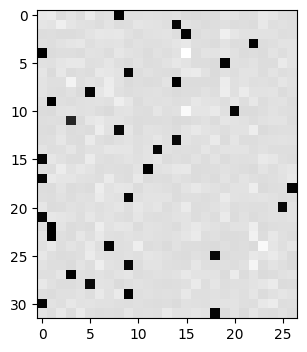

In [26]:
plt.figure(figsize=(4, 4))
plt.imshow(dlogits.detach(), cmap = 'gray')

In [27]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [31]:
# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10 

hprebn          | exat: False | approximate: True  | maxdiff: 1.3969838619232178e-09


In [ ]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# Init
n_embd = 10                                                         # the dimensionality of the character embedding vectors
n_hidden = 200                                                      # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)                       # for reproducibility
C = torch.randn((vocab_size, n_embd), generator= g)

#Layer1
W1 = torch.Generator((block_size * n_embd, n_hidden), generator = g) * (5/3) / ((block_size * n_embd, n_hidden)**0.5)
b1 = torch.Generator((n_hidden), generator = g) * 0.1

#Layer2
W2 = torch.Generator((n_hidden, vocab_size), generator = g) * 0.1
b2 = torch.Generator((vocab_size), generator = g) * 0.1

#Batchnorm Parameters
bngain = torch.randn((1, n_hidden), generator=g) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden), generator=g) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelements() for p in parameters)) # Number of parameters in total

for p in parameters:
    p.requires_grad = True

# Same optimization as lst time
max_steps = 100000
batch_size = 32
n = batch_size
lossi = []

# We'll use this context manager for efficiancy once we'll update the backward pass manually
# with torch.no_grad():

for i in range(max_steps):

    #minibatch Construct
    ix = torch.randint(0, len(Xtr), batch_size, generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]                                           #Batch X, Y

    #forward pass
    emb = C[Xb]
    embcat = emb.vi



In [ ]:
# I got Lazy --> skipping hardwork

In [37]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 100000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
#with torch.no_grad():

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hprebn = embcat @ W1 + b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmean = hprebn.mean(0, keepdim=True)
  bnvar = hprebn.var(0, keepdim=True, unbiased=True)
  bnvar_inv = (bnvar + 1e-5)**-0.5
  bnraw = (hprebn - bnmean) * bnvar_inv
  hpreact = bngain * bnraw + bnbias
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward() # use this for correctness comparisons, delete it later!

  # manual backprop! #swole_doge_meme
  # -----------------
  # YOUR CODE HERE :)
  dC, dW1, db1, dW2, db2, dbngain, dbnbias = None, None, None, None, None, None, None
  grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p, grad in zip(parameters, grads):
    p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
    #p.data += -lr * grad # new way of swole doge TODO: enable

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  # break

12297
      0/ 100000: 3.7861
  10000/ 100000: 2.1725
  20000/ 100000: 2.3575
  30000/ 100000: 2.4304
  40000/ 100000: 2.0337
  50000/ 100000: 2.3778
  60000/ 100000: 2.3839
  70000/ 100000: 2.0950
  80000/ 100000: 2.3208
  90000/ 100000: 2.1717


In [45]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 100000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

    # kick off optimization
    for i in range(max_steps):

        # minibatch construct
        ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
        Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

        # forward pass
        emb = C[Xb] # embed the characters into vectors
        embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
        # Linear layer
        hprebn = embcat @ W1 + b1 # hidden layer pre-activation
        # BatchNorm layer
        # -------------------------------------------------------------
        bnmean = hprebn.mean(0, keepdim=True)
        bnvar = hprebn.var(0, keepdim=True, unbiased=True)
        bnvar_inv = (bnvar + 1e-5)**-0.5
        bnraw = (hprebn - bnmean) * bnvar_inv
        hpreact = bngain * bnraw + bnbias
        # -------------------------------------------------------------
        # Non-linearity
        h = torch.tanh(hpreact) # hidden layer
        logits = h @ W2 + b2 # output layer
        loss = F.cross_entropy(logits, Yb) # loss function

        # backward pass
        # for p in parameters:
        #     p.grad = None
        # loss.backward() # use this for correctness comparisons, delete it later!

        # manual backprop! #swole_doge_meme
        # -----------------
        # YOUR CODE HERE :)
        dlogits = F.softmax(logits, 1)
        dlogits[range(n), Yb] -= 1
        dlogits /= n
        # 2nd layer backprop
        dh = dlogits @ W2.T
        dW2 = h.T @ dlogits
        db2 = dlogits.sum(0)
        # tanh
        dhpreact = (1.0 - h**2) * dh
        # batchnorm backprop
        dbngain = (bnraw * dhpreact).sum(0, keepdim=True)
        dbnbias = dhpreact.sum(0, keepdim=True)
        dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))
        # 1st layer
        dembcat = dhprebn @ W1.T
        dW1 = embcat.T @ dhprebn
        db1 = dhprebn.sum(0)
        # embedding
        demb = dembcat.view(emb.shape)
        dC = torch.zeros_like(C)
        for k in range(Xb.shape[0]):
            for j in range(Xb.shape[1]):
                ix = Xb[k,j]
                dC[ix] += demb[k,j]
            grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]
            # -----------------

        # update
        lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
        for p, grad in zip(parameters, grads):
            # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
            p.data += -lr * grad # new way of swole doge TODO: enable

        # track stats
        if i % 10000 == 0: # print every once in a while
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

        # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
        # break

12297
      0/ 100000: 3.8105
  10000/ 100000: 2.1678
  20000/ 100000: 2.4085
  30000/ 100000: 2.4677
  40000/ 100000: 1.9860
  50000/ 100000: 2.3712
  60000/ 100000: 2.3101
  70000/ 100000: 2.0730
  80000/ 100000: 2.3514
  90000/ 100000: 2.0595


In [38]:
# useful for checking your gradients
# for p,g in zip(parameters, grads):
#   cmp(str(tuple(p.shape)), g, p)

In [39]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)


In [40]:
# Andrej achieved:
# train 2.0718822479248047
# val 2.1162495613098145

In [36]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

eria.
kmyaz.
hzelend.
hyal.
qefmrngejgrneg.
azejedie.
iulemi.
jea.
ekein.
anlearieltzi.
hvqep.
b.
shdbn.
gxhiries.
kkajeweelqqxnbpolfiua.
kyvd.
rhylqufmekg.
kaajqhoflyan.
hja.
sadylisuf.


In [41]:
import time

start_time = time.time()

# Code to be timed
for i in range(1000000):
    pass

end_time = time.time()

print("Execution time:", end_time - start_time, "seconds")

Execution time: 0.041661739349365234 seconds
